In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [5]:
def sigma_function(time,t_0,magnitude):
    if time < t_0:
        return magnitude
    else:
        return 10**(-5)

In [6]:
def position_to_indices(x, y, x_values, y_values):
    # j is for x (column), i is for y (row)
    j = np.abs(x_values - x).argmin()
    i = np.abs(y_values - y).argmin()
    j = np.clip(j, 0, len(x_values) - 1)
    i = np.clip(i, 0, len(y_values) - 1)
    return i, j

In [7]:
def get_pes_values(X, PES, x_values, y_values):
    indices = [position_to_indices(x, y, x_values, y_values) for x, y in X]
    pes_values = np.array([PES[i, j] for i, j in indices])
    return pes_values

In [8]:
def best_particle(X, PES):
    global x_values, y_values
    """
    X: array of shape (N_particles, 2) with [x, y] positions
    PES: 2D array of potential energy values
    x_values, y_values: grid arrays
    Returns: [x, y] of the best particle (lowest PES value)
    """
    pes_values = get_pes_values(X, PES, x_values, y_values)
    best_idx = np.argmin(pes_values)
    return X[best_idx]


In [9]:
def reflection_square(X_old, V, square_length_X,square_length_Y, reflection_counter):
    global h
    X_new = X_old + h * V
    
    # Create masks for boundary crossings
    reflect_x = (X_new[:, 0] > square_length_X) | (X_new[:, 0] < 0)
    reflect_y = ((X_new[:, 1]) > square_length_Y) | ((X_new[:, 1]) < 0)
    
    # Update reflection counter
    original_counter = reflection_counter[0]
    reflection_counter[0] = original_counter + np.sum(reflect_x) + np.sum(reflect_y)
    
    # Process X-axis reflections
    if np.any(reflect_x):
        a_x = X_old[reflect_x]
        b_x = V[reflect_x]
        
        # Calculate intersection times for X-boundary
        Vx = b_x[:, 0]
        boundary_x = np.where(Vx > 0, square_length_X, 0)
        tau_x = (boundary_x - a_x[:, 0]) / Vx
        
        # Handle Vx=0 cases (particles already outside boundary)
        tau_x = np.where(Vx == 0, h, tau_x)
        
        # Move to boundary and reflect velocity
        X_tau_x = a_x.copy()
        X_tau_x[:, 0] = boundary_x
        V_hat_x = b_x.copy()
        V_hat_x[:, 0] *= -1
        
        # Update positions and velocities
        X_new[reflect_x] = X_tau_x + (h - tau_x[:, None]) * V_hat_x
        V[reflect_x] = V_hat_x
    
    # Process Y-axis reflections
    if np.any(reflect_y):
        a_y = X_old[reflect_y]
        b_y = V[reflect_y]
        
        # Calculate intersection times for Y-boundary
        Vy = b_y[:, 1]
        boundary_y = np.where(Vy > 0, square_length_Y, 0)
        tau_y = (boundary_y - a_y[:, 1]) / Vy
        
        # Handle Vy=0 cases
        tau_y = np.where(Vy == 0, h, tau_y)
        
        # Move to boundary and reflect velocity
        X_tau_y = a_y.copy()
        X_tau_y[:, 1] = boundary_y
        V_hat_y = b_y.copy()
        V_hat_y[:, 1] *= -1
        
        # Update positions and velocities
        X_new[reflect_y] = X_tau_y + (h - tau_y[:, None]) * V_hat_y
        V[reflect_y] = V_hat_y
    
    return X_new, V


In [10]:
def PSO(X_old, V_old,objective_function, Lambda, gamma, sigma,square_length_X,square_length_Y, reflection_counter, square = True):
    # X: particle positions
    # weighted_average_X: weighted average of particle positions
    # V: particle velocities
    # Lambda: interaction coefficient
    # gamma: inertia coefficient
    # sigma: exploration coefficient
    # returns updated X, weighted_average_X, V
    N_particles = X_old.shape[0]

    global h
    X_hat, V_hat = reflection_square(X_old,V_old,square_length_X,square_length_Y,reflection_counter)
    X_new = X_hat
    best_particle_X = best_particle(X_hat,objective_function)
    #weighted_average_X = weighted_average(X_new,alpha,objective_function)
    V_new = V_hat - Lambda*(X_new-best_particle_X)*h-gamma*V_hat*h+sigma*np.sqrt(h)*np.random.randn(N_particles,1)
    
    return X_new, V_new

In [11]:
def success_function(X, global_minima, objective_function):
    best_part= best_particle(X, objective_function)
    if global_minima.ndim == 1:
        distances = np.linalg.norm(best_part - global_minima)
    else:
        distances = np.linalg.norm(best_part - global_minima,axis=1)
    return np.any(distances < 0.2)

In [12]:
from ase.constraints import FixAtoms, FixedLine
from ase.optimize import BFGS
from ase import Atom


import ase

# More modules
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [13]:
# Read surface

from ase.io import read
surface = read('structures/surface_supercell.xyz')

In [14]:
# Calculate the potential energy of the bare surace. We use the EMT() calculator, to make it comparable to the given function

#surface.set_calculator(EMT())
#E_surface = surface.get_potential_energy()
#surface.set_calculator(None)                 # Unset calculator
E_surface = 6.87
print(f"Energy of the structure: {E_surface}")

Energy of the structure: 6.87


In [15]:
# Define the values of the (x, y) grid (Ranges are given above)

x_min, x_max = 0, 16.65653
y_min, y_max = 0, 2.884996

spatial_resolution = 0.015         # Spatial resolution we will aim for (hopefully, very small)

N_x = int(np.ceil( (x_max-x_min) / spatial_resolution)) + 1      # Number of points in x to achieve desired resolution
N_y = int(np.ceil( (y_max-y_min) / spatial_resolution)) + 1      # Number of points in y to achieve desired resolution
                         
x_values = np.linspace(x_min, x_max, N_x)
y_values = np.linspace(y_min, y_max, N_y)

# Array to store calculations of PES

PES_2D_array = np.zeros((N_x, N_y))
print(f'Shape of PES array = {PES_2D_array.shape}')
print(f'Total number of calculations = {N_x*N_y}')

Shape of PES array = (1112, 194)
Total number of calculations = 215728


We are plotting an array of shape (y, x) = (194, 1112)


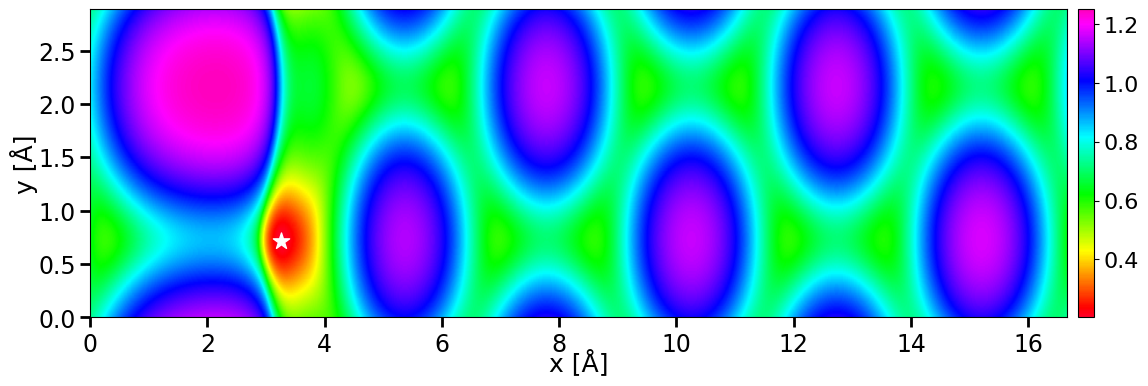

In [16]:
# Plot PES, with the global minimum. First open file

PES = np.load('PES_2D_array.npy')
PES = PES.T
print(f'We are plotting an array of shape (y, x) = {PES.shape}')

globalmin_y, globalmin_x = np.unravel_index(np.argmin(PES), PES.shape)
best_x, best_y = x_values[globalmin_x], y_values[globalmin_y]

fig = plt.figure(figsize = (15, 4))
ax = fig.add_subplot(111)
cax = ax.imshow(PES, extent = [x_min, x_max, y_min, y_max], origin = 'lower', aspect = 'auto', cmap = 'gist_rainbow')
ax.scatter(best_x, best_y, marker = '*', s = 150, color = 'white')
ax.set_xlabel('x [Å]', fontsize = 18, labelpad = -5)
ax.set_ylabel('y [Å]', fontsize = 18, labelpad = 0)
#ax.set_title('E(x,y)', size = 20)
ax.tick_params(direction = 'out', which = 'major', length = 7, width = 2, labelsize = 17)

colorbar = fig.colorbar(cax, pad = 0.01)
colorbar.ax.tick_params(labelsize = 16)

#plt.savefig('Figures/PES.png', dpi = 400, bbox_inches = 'tight');

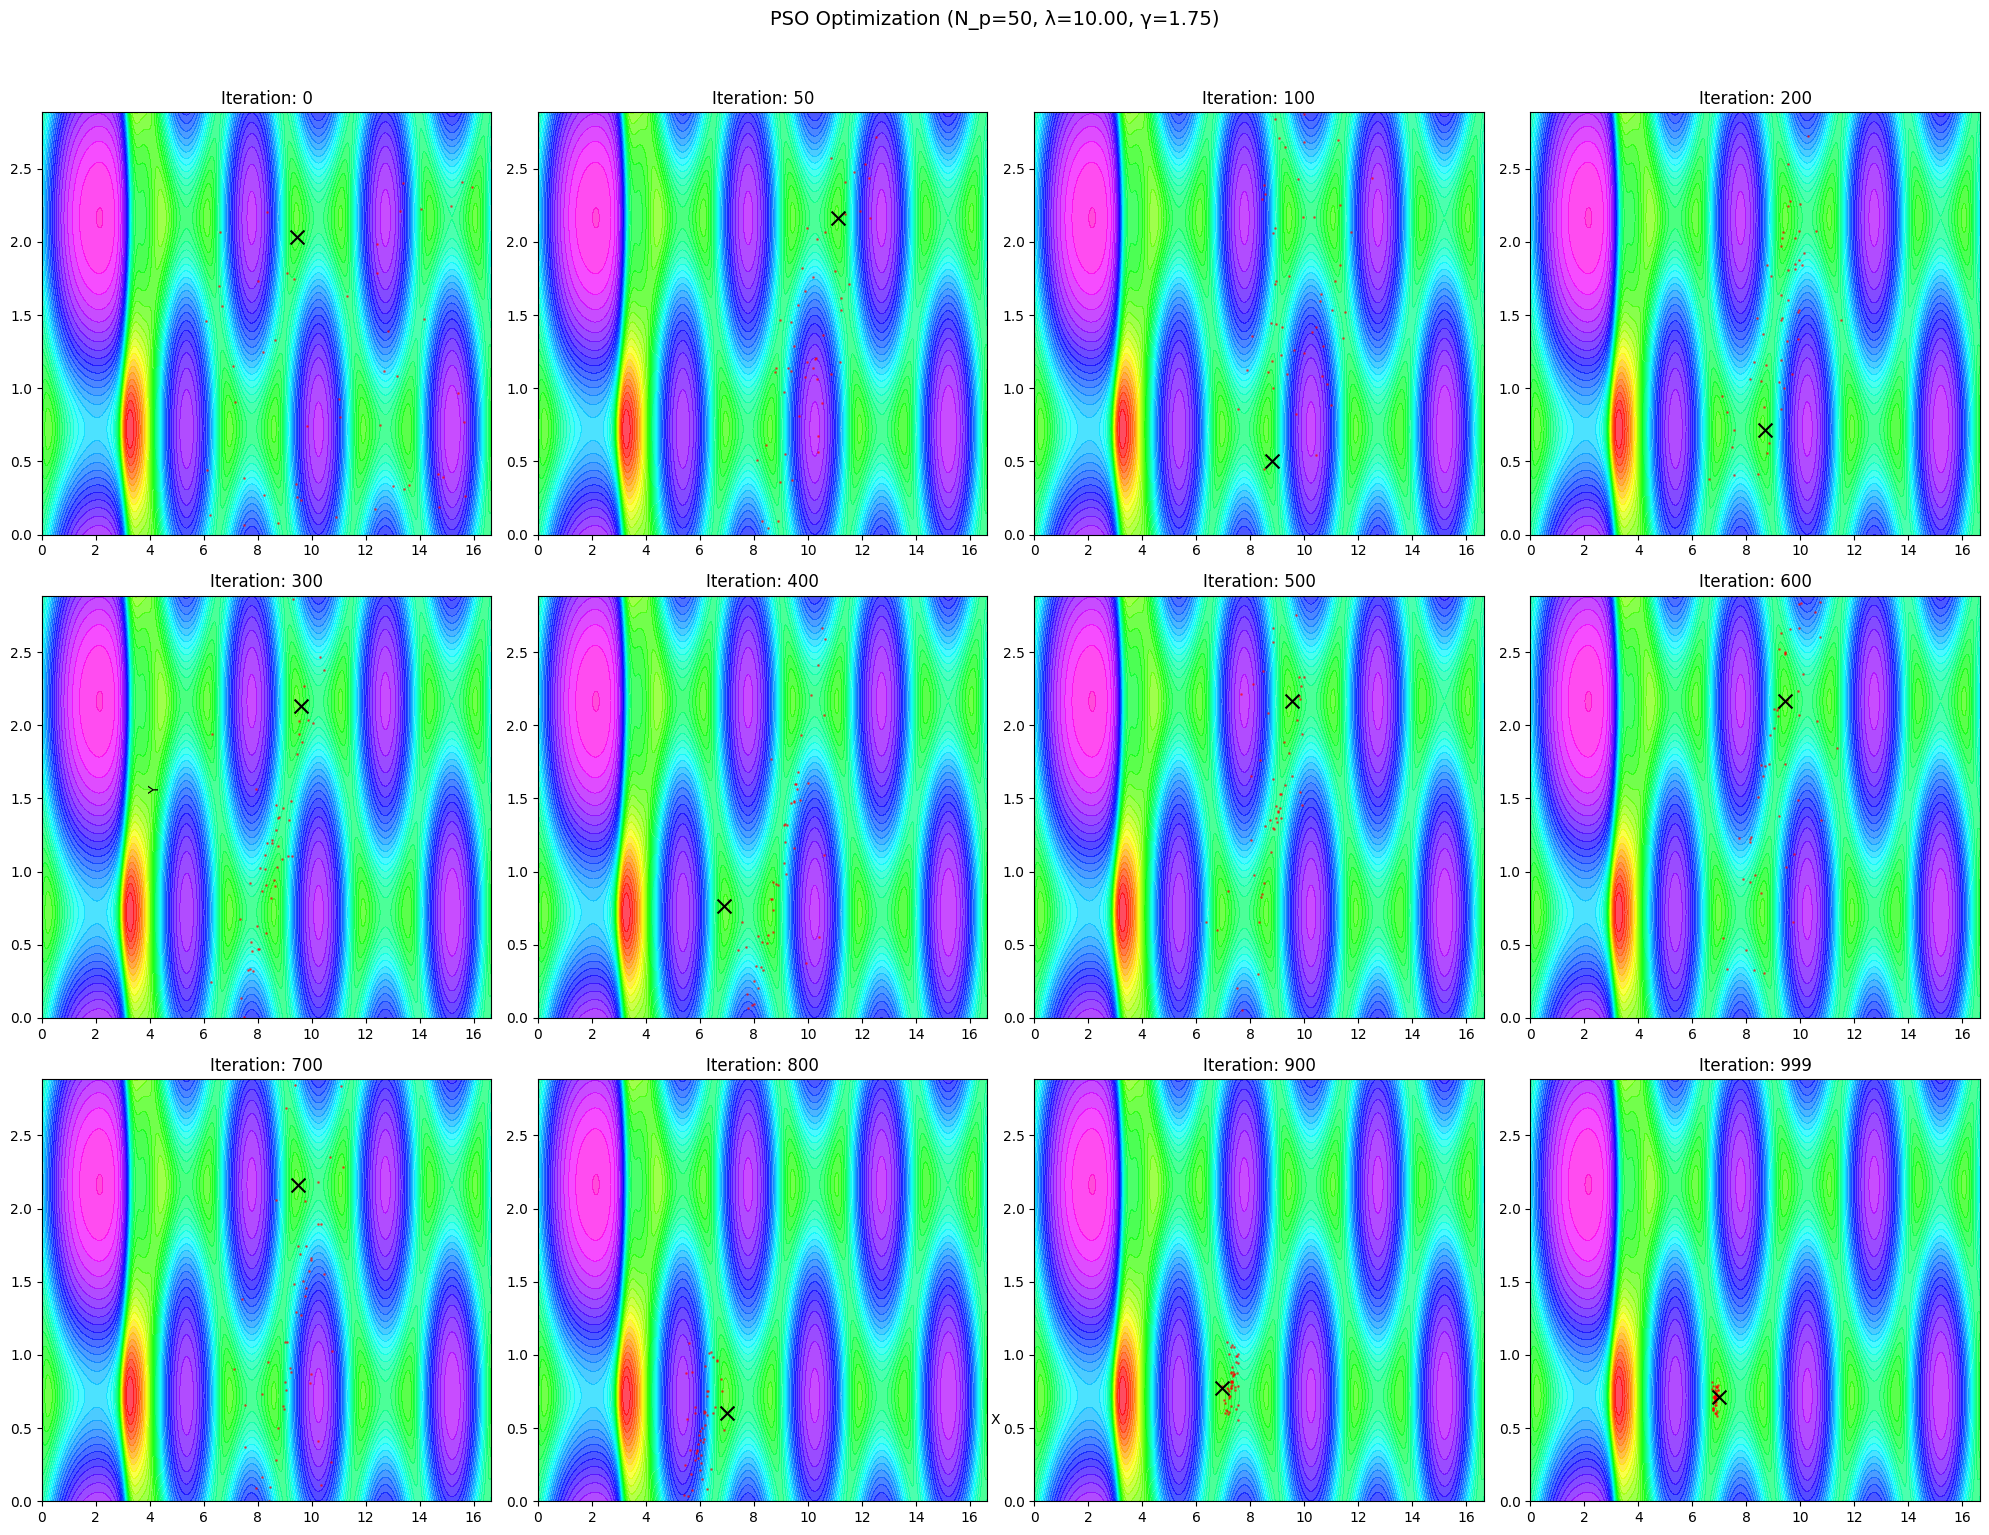

In [17]:
# Grid search for optimal parameters (complete implementation)

# Parameters (preserved from original)
Lambda = 10
gamma = 1.75
N_particles = 50
square_length_X = 16.65653
square_length_Y = 2.884996
objective_function = PES
T = 10 
h = 0.01     

# Initialization (preserved)

# Generate x and y coordinates in the specified ranges
x_positions = np.random.uniform(6, 16, N_particles)
y_positions = np.random.uniform(0, 2.6, N_particles)

# Combine into a (N_particles, 2) array
particle_positions_X = np.column_stack((x_positions, y_positions))

particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0

# Create a grid for the contour plot (preserved)
x = np.linspace(0, x_max, 1112)
y = np.linspace(0, y_max, 194)
X, Y = np.meshgrid(x, y)
Z = PES
# Plot configuration (modified for subfigures)
reflection_counter = [0]
plot_list = [0,50,100,200,300,400,500,600,700,800,900,999]
n_plots = len(plot_list)
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))

# Create figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axs = axs.flatten()
plot_idx = 0

# PSO loop (preserved with subplot modification)
while time < T:
    iteration = int(time/h)
    if iteration in plot_list:
        ax = axs[plot_idx]
        contour = ax.contourf(X, Y, Z, levels=50, cmap='gist_rainbow', alpha=0.7)
        ax.set_xlim(0, 16.65653)
        ax.set_ylim(0, 2.884996)
        ax.set_title(f'Iteration: {iteration}')
        ax.plot(particle_positions_X[:,0], particle_positions_X[:,1], 'ro', markersize=1, alpha=0.5)
        best_min_x, best_min_y = best_particle(particle_positions_X,PES)
        ax.scatter(best_min_x, best_min_y, color='black', s=100, zorder=5, marker='x')
        ax.scatter(globalmin_x, globalmin_y, color='orange', s=100, zorder=5, marker='*')
        plot_idx += 1
    
    # PSO update (preserved)
    sigma = sigma_function(time, t_0 = 7, magnitude = 5)
    particle_positions_X, particle_velocities_V = PSO(
        particle_positions_X, particle_velocities_V,
        objective_function, Lambda, gamma, sigma,
        square_length_X,square_length_Y, reflection_counter, square=True
    )
    time += h

# Final figure adjustments (new)
for i in range(plot_idx, len(axs)):
    fig.delaxes(axs[i])

fig.suptitle(
    f'PSO Optimization (N_p={N_particles}, λ={Lambda:.2f}, γ={gamma:.2f})',
    y=1.02, fontsize=14
)
fig.text(0.5, 0.08, 'X', ha='center', va='center')
fig.text(0.08, 0.5, 'Y', ha='center', va='center', rotation='vertical')

plt.tight_layout()
plt.show()



In [18]:
for x, y in particle_positions_X[:5]:
    i, j = position_to_indices(x, y, x_values, y_values)
    print(f"x={x}, y={y} => i={i}, j={j}")

x=6.83617027594039, y=0.6570332929521402 => i=44, j=456
x=6.747911041301479, y=0.637726126746466 => i=43, j=450
x=6.885618817481831, y=0.7324880211859913 => i=49, j=459
x=6.950635872909345, y=0.7922334454461147 => i=53, j=464
x=6.758091120595003, y=0.6226038499217162 => i=42, j=451


In [19]:
print(f"PES.shape: {PES.shape}, len(x_values): {len(x_values)}, len(y_values): {len(y_values)}")

PES.shape: (194, 1112), len(x_values): 1112, len(y_values): 194


In [20]:
x_conversion = (N_x-1)/x_max
y_conversion = (N_y-1)/y_max
grad_y, grad_x = np.gradient(PES)
def simulated_annealing(walkers = N_particles, T = 10, learning_rate = h):
    global x_conversion, y_conversion, x_max, y_max

    final_positions = np.zeros((walkers,2))
    start_positions = np.zeros((walkers,2))
    lost_walkers = 0

    for i in range(walkers):
        x0 = np.random.uniform(6, 16.65653)
        y0 = np.random.uniform(0, 2.6)

        x_new, y_new = x0, y0
        start_positions[i] = x0, y0
        iteration = 1
        x_new = np.clip(x_new, 0, x_max)
        y_new = np.clip(y_new, 0, y_max)
        time = 0
        while time < T:
            # So that it does not go outside 2darray:
            if (x_new > x_max): 
                x_new = (N_x-1)/x_conversion
            if (y_new > y_max): 
                y_new = (N_y-1)/y_conversion
            if y_new < 0: 
                y_new = 0
            if x_new < 0:
                x_new = 0
                
            gx = grad_x[int(y_new*y_conversion), int(x_new*x_conversion)]
            gy = grad_y[int(y_new*y_conversion), int(x_new*x_conversion)]

            exploration_term = np.sqrt(2/(np.log(1+iteration*learning_rate))) * np.random.randn(2)*np.sqrt(learning_rate)

            x = x_new - learning_rate * gx + exploration_term[0]
            y = y_new - learning_rate * gy + exploration_term[1]

            difference = np.sqrt((x - x_new)**2 + (y - y_new)**2)

            x_new, y_new = x, y
            iteration = iteration + 1
            time += learning_rate
        final_positions[i] = x_new,y_new
        
    
    return start_positions, final_positions

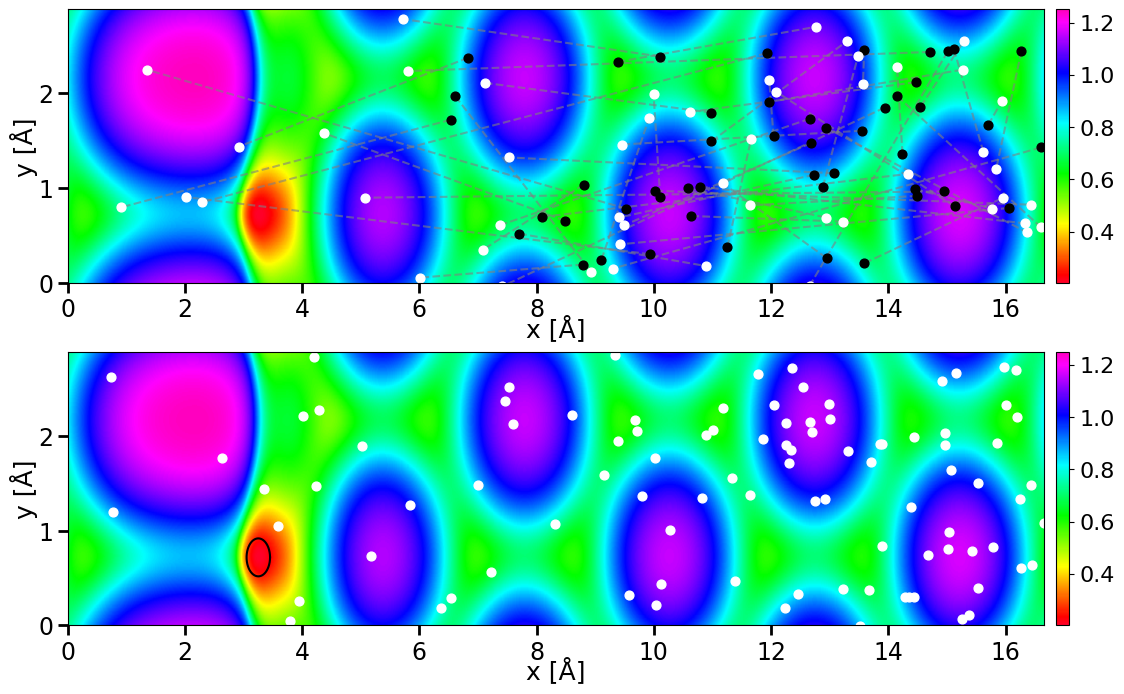

In [48]:
walkers1 = 50
start_pos1, final_pos1 = simulated_annealing(walkers1,T, h)

walkers2 = 100
start_pos2, final_pos2 = simulated_annealing(walkers2,T, h)

fig = plt.figure(figsize = (15, 8))
plt.subplots_adjust(hspace = 0.25)

ax1 = fig.add_subplot(211)
cax1 = ax1.imshow(PES, extent = [x_min, x_max, y_min, y_max], origin = 'lower', aspect = 'auto', cmap = 'gist_rainbow')
ax1.scatter(start_pos1[:, 0], start_pos1[:, 1], color = 'black', s = 40)
ax1.scatter(final_pos1[:, 0], final_pos1[:, 1], color = 'white', s = 40)
ax1.set_xlabel('x [Å]', fontsize = 18, labelpad = -5)
ax1.set_ylabel('y [Å]', fontsize = 18, labelpad = 0)
ax1.tick_params(direction = 'out', which = 'major', length = 7, width = 2, labelsize = 17)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
colorbar1 = fig.colorbar(cax1, pad = 0.01)
colorbar1.ax.tick_params(labelsize = 16)

for i in range(walkers1):
    ax1.plot([start_pos1[i, 0], final_pos1[i, 0]], [start_pos1[i, 1], final_pos1[i, 1]], linestyle = '--', color = 'gray', alpha = 0.6,
            zorder = 0)


ax2 = fig.add_subplot(212)
cax2 = ax2.imshow(PES, extent = [x_min, x_max, y_min, y_max], origin = 'lower', aspect = 'auto', cmap = 'gist_rainbow')
ax2.scatter(final_pos2[:, 0], final_pos2[:, 1], color = 'white', s = 40)
ax2.set_xlabel('x [Å]', fontsize = 18, labelpad = -5)
ax2.set_ylabel('y [Å]', fontsize = 18, labelpad = 0)
ax2.tick_params(direction = 'out', which = 'major', length = 7, width = 2, labelsize = 17)
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
colorbar2 = fig.colorbar(cax2, pad = 0.01)
colorbar2.ax.tick_params(labelsize = 16)

r = 0.2
theta = np.linspace(0, 2 * np.pi, 1000)
x_circle, y_circle = best_x + r * np.cos(theta), best_y + r * np.sin(theta)
ax2.plot(x_circle, y_circle, color = 'black');

#plt.savefig('Figures/Grad_descent.png', dpi = 400, bbox_inches = 'tight');

In [38]:
Lambda = 10
gamma = 1.75
N_particles = 50
square_length_X = 16.65653
square_length_Y = 2.884996
objective_function = PES
T = 10 
h = 0.01     
global_min_PES = np.array([best_x, best_y])
# Initialization (preserved)

N_iter = 1000


x = np.linspace(0, x_max, 1112)
y = np.linspace(0, y_max, 194)
X, Y = np.meshgrid(x, y)
Z = PES
# Plot configuration (modified for subfigures)
reflection_counter = [0]

# Create figure with subplots

# PSO loop (preserved with subplot modification)
success = 0
for i in range(N_iter):
    time = 0
    start_pos,final_pos = simulated_annealing(N_particles,T, h)
    if success_function(final_pos, global_min_PES, objective_function):
            success += 1
success_rate = success / N_iter * 100

print(f"T: {T}, step-size: {h}, Success rate: {success_rate:.2f}%, Reflections:")

T: 10, step-size: 0.01, Success rate: 6.10%, Reflections:


In [39]:
Lambda = 10
gamma = 1.75
N_particles = 50
square_length_X = 16.65653
square_length_Y = 2.884996
objective_function = PES
T = 10 
h = 0.01     
global_min_PES = np.array([best_x, best_y])
# Initialization (preserved)

N_iter = 1000


# PSO loop (preserved with subplot modification)
success = 0
for i in range(N_iter):
    time = 0
    reflection_count = [0]
    x_positions = np.random.uniform(6, 16, N_particles)
    y_positions = np.random.uniform(0, 2.6, N_particles)
    particle_positions_X = np.column_stack((x_positions, y_positions))
    particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))

    while time < T:
        iteration = int(time/h)
        # PSO update (preserved)
        sigma = sigma_function(time, t_0 = 7, magnitude = 5)
        particle_positions_X, particle_velocities_V = PSO(
            particle_positions_X, particle_velocities_V,
            objective_function, Lambda, gamma, sigma,
            square_length_X,square_length_Y, reflection_counter, square=True
        )
        time += h
    if success_function(particle_positions_X, global_min_PES, objective_function):
            success += 1
success_rate = success / N_iter * 100

print(f"T: {T}, step-size: {h}, Success rate: {success_rate:.2f}%, Reflections: {reflection_count[0]}")

T: 10, step-size: 0.01, Success rate: 42.40%, Reflections: 0
